
Test the functions related to getCommunities().

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata as ad
import statistics

In [2]:
import spacells as spc

In [3]:
np.random.seed(42)
print(ad.__version__)

0.9.2


# Read data

In [4]:
adata = ad.read('../data/example_adata.h5ad')
adata.obs["id"] = adata.obs_names

The following steps compute the communities based on SOX10+ or CD45+ cells.

In [5]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id'
    uns: 'all_markers'

In [6]:
print(list(adata.var_names))

['SOX10', 'CD8A', 'CD3E', 'CD45', 'panCK', 'CD4', 'aSMA']


In [7]:
markders_of_interest = ["SOX10","CD45"]

# setGate or setGates

In [8]:
spc.prep.setGate(adata, "SOX10", 7.5, debug = True)
spc.prep.setGate(adata, "CD45", 8.0, debug = True)

False    91523
True     46293
Name: SOX10_b, dtype: int64
False    98518
True     39298
Name: CD45_b, dtype: int64


In [9]:
gate_file = "../data/example_gates.csv"
spc.prep.setGates(adata, gate_file, debug = True)

gate: 7.5 False    91523
True     46293
Name: SOX10_b, dtype: int64
gate: 7.0 False    116836
True      20980
Name: CD8A_b, dtype: int64
gate: 7.2 False    111855
True      25961
Name: CD3E_b, dtype: int64
gate: 8.0 False    98518
True     39298
Name: CD45_b, dtype: int64
gate: 6.5 False    129174
True       8642
Name: panCK_b, dtype: int64
gate: 7.4 False    113595
True      24221
Name: CD4_b, dtype: int64
gate: 5.7 False    129847
True       7969
Name: aSMA_b, dtype: int64


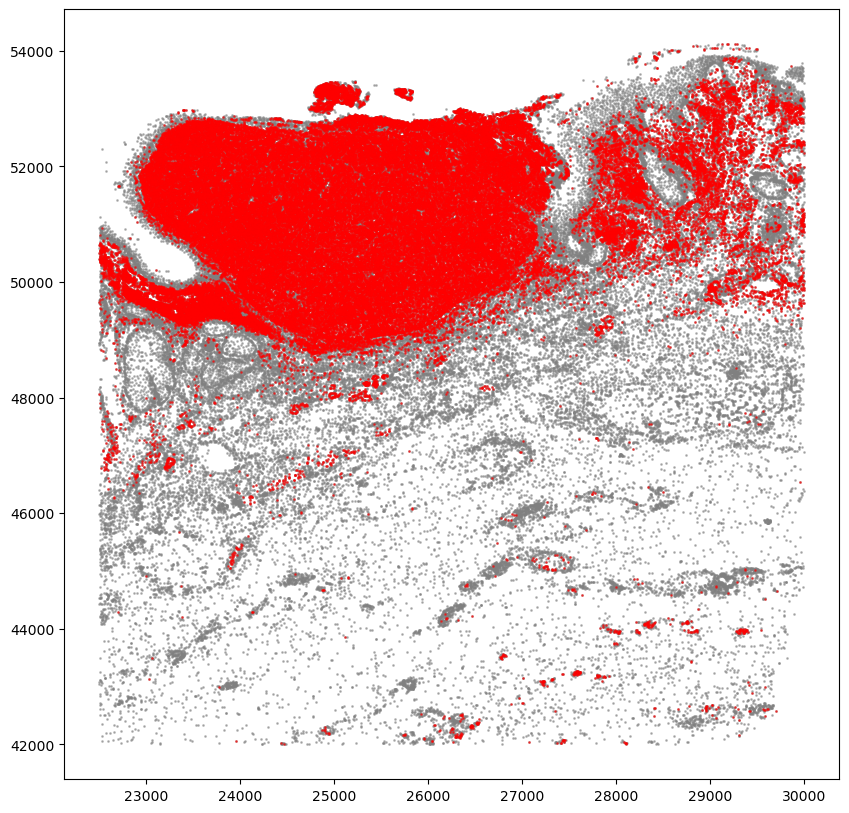

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="grey", alpha=0.5)

tmp = adata[adata.obs.SOX10_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

tmp = adata[adata.obs.CD45_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

plt.show()

# estimateInitialDistance

In [11]:
# Downsampling is desired; otherwise slow
# Use for estimating the eps parameter

# distance_candidates = spc.spatial.estimateInitialDistance(adata, 
#                                               markders_of_interest, 
#                                               sampling_ratio=0.3)
# print(statistics.quantiles(distance_candidates))

# getCommunities

In [12]:
# %%timeit -r1 -n10
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, markders_of_interest, 
                                 eps= 100, 
                                 newcolumn = communitycolumn)


In [13]:
print("number of communiteis:", len(ret[0]))
# print(adata.obs[communitycolumn].value_counts())

number of communiteis: 26


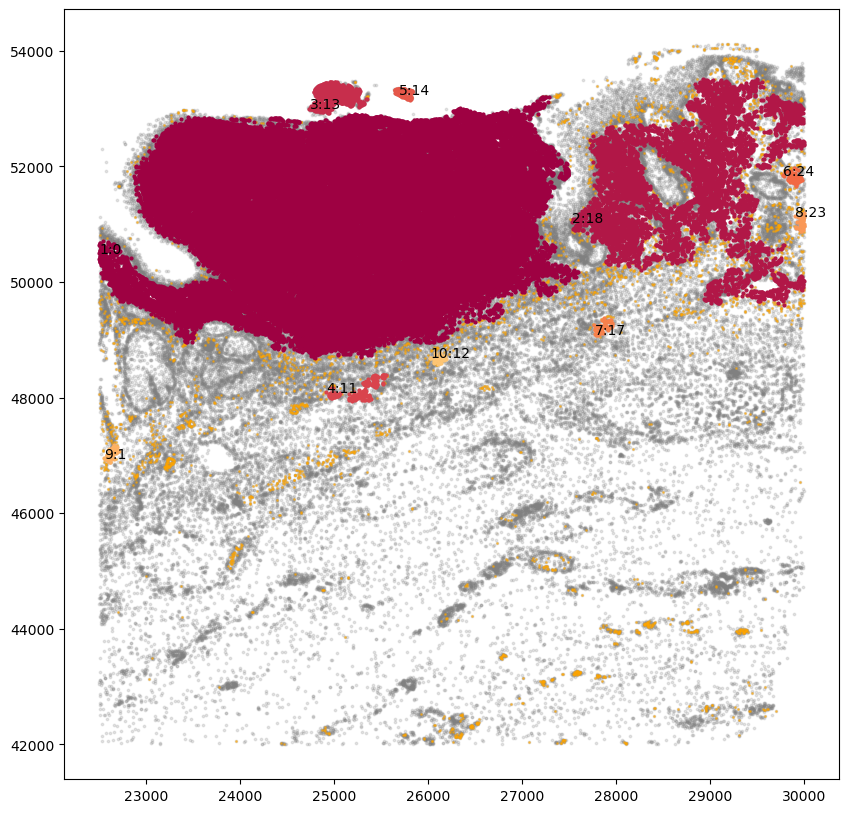

In [14]:
# input: output of getCommunities()
markersize = 2

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1

plt.show()
 

In [15]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(clusters_idx_sorted[:plot_first_n_clusters])
print(ret[0][:plot_first_n_clusters])

[0, 18, 13, 11, 14, 24, 17, 23, 1, 12]
[(68743, 0), (8580, 18), (1222, 13), (217, 11), (161, 14), (97, 24), (75, 17), (67, 23), (62, 1), (59, 12)]


In [16]:
# Here we choose the three largest ones of interest
communityIndexList = [0, 18, 13]

# getBoundary    
# getExtendedBoundary     
# getShrunkenBoundary

In [17]:
import importlib
import _utils
import _getBoundary
import _getExtendedBoundary
import _getShrunkenBoundary

In [18]:
importlib.reload(_utils)
importlib.reload(_getBoundary)

from _getBoundary import getBoundary
from _utils import *

boundaries_allrings, polygons_allrings = getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=40, 
                         nedges_min = 3,
                         nedges_out_min = 3)
boundary_edges_allrings = getEdgesOnBoundary(boundaries_allrings)

boundaries, boundary_polygons = getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=100, 
                         nedges_min = 20,
                         nedges_out_min = 20)
boundary_edges = getEdgesOnBoundary(boundaries)

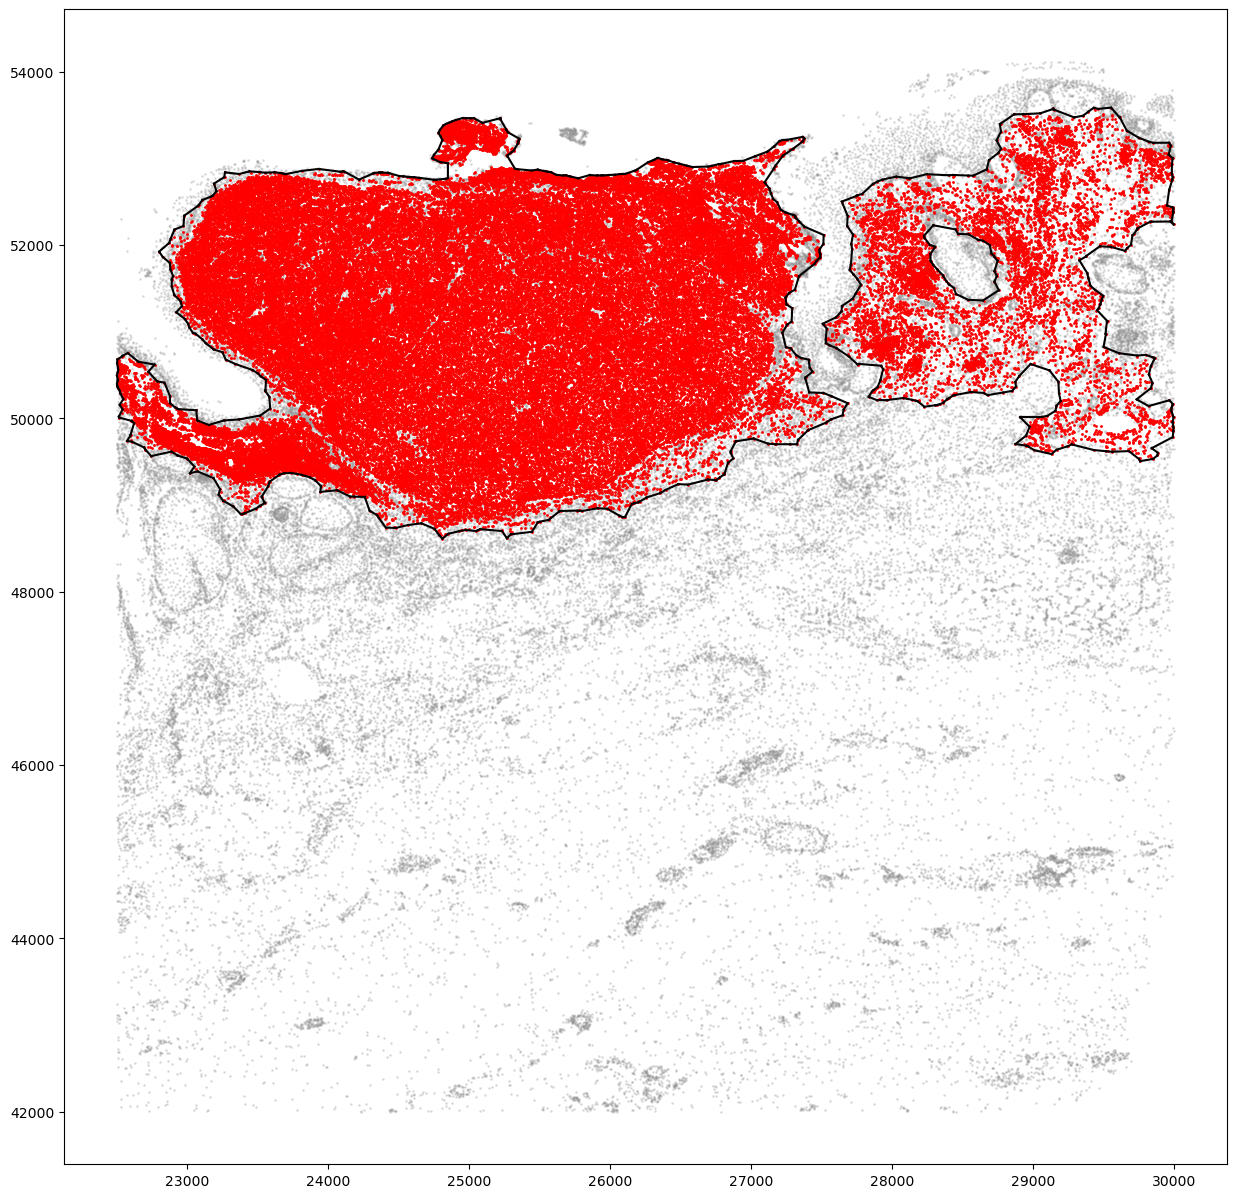

In [19]:
# all rings, including touching ones

markersize = 1

fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for ed in boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

plt.show()

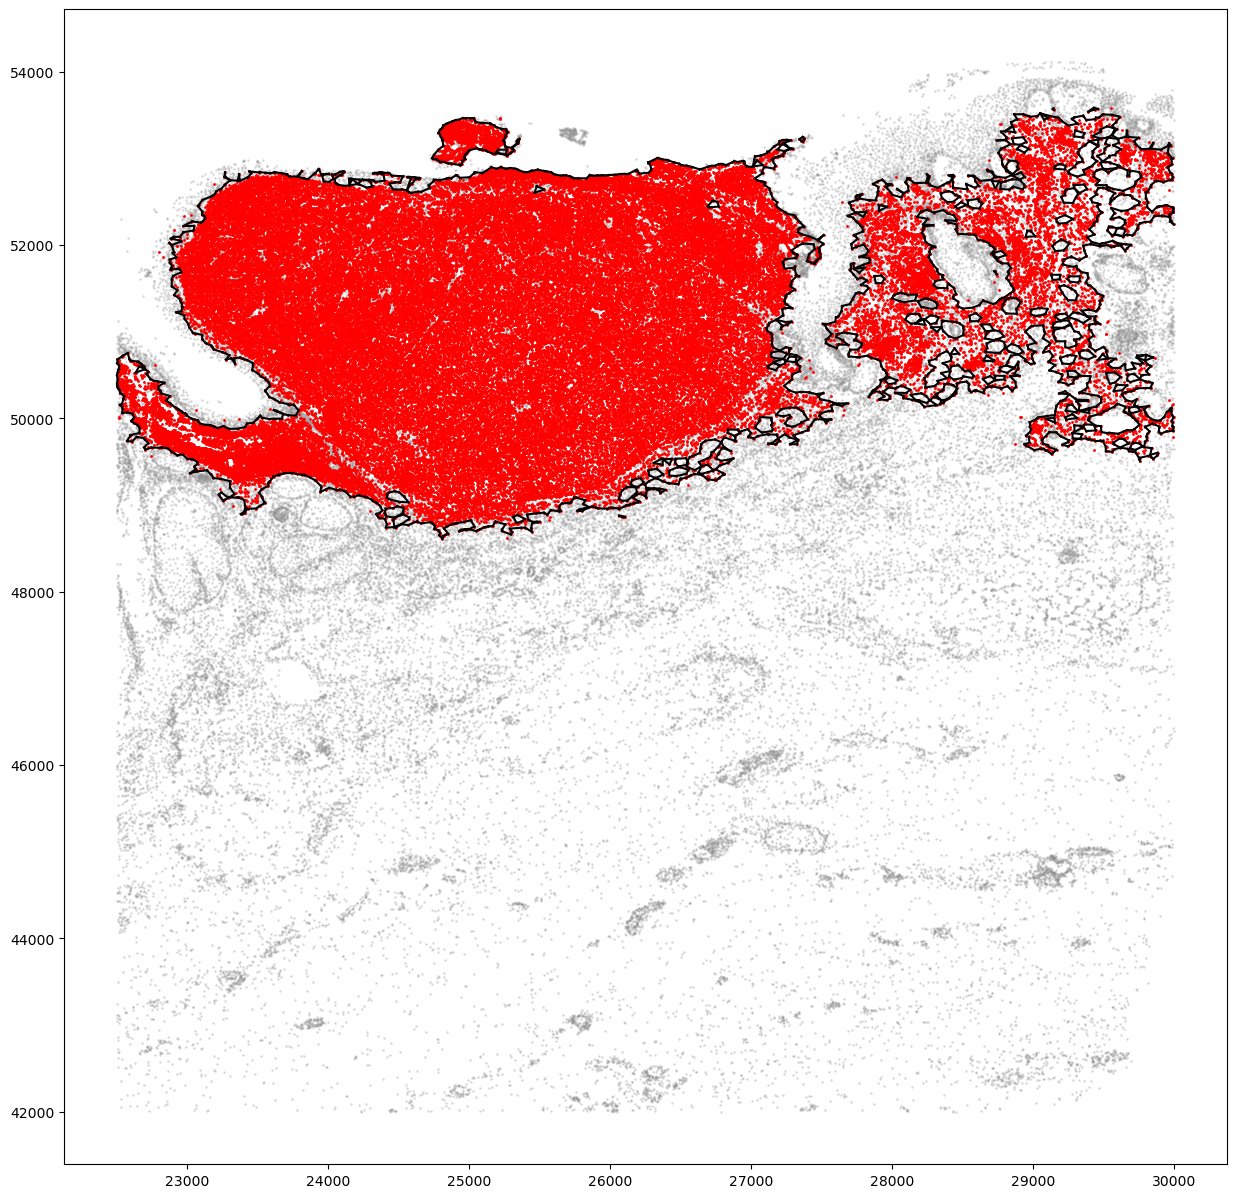

In [20]:
# removed small rings
markersize = 1

fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for ed in boundary_edges_allrings:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

plt.show()

In [21]:
# additional internal boundary rings for testing
p1 = (25000, 50000)
p2 = (24500, 51000)
p3 = (25000, 52000)
p4 = (25500, 51000)
p5 = (26500, 50000)
p6 = (26000, 51000)
p7 = (26500, 52000)
p8 = (27000, 51000)
fake_edge1 = np.array(
    [
        [p1, p2],
        [p2, p3],
        [p3, p4],
        [p4, p1]
    ]
)
fake_edge2 = np.array(
    [
        [p5, p6],
        [p6, p7],
        [p7, p8],
        [p8, p5]
    ]
)
boundaries[0].extend([fake_edge1, fake_edge2])
boundary_edges = getEdgesOnBoundary(boundaries)
boundary_polygons = getPolygons(boundaries)

In [34]:
importlib.reload(_utils)
importlib.reload(_getShrunkenBoundary)

from _utils import *
from _getShrunkenBoundary import *


shrunken_boundaries, shrunken_boundary_polygons = getShrunkenBoundary(
    boundaries, offset=200, minsize=4
)
shrunken_boundary_edges = getEdgesOnBoundary(shrunken_boundaries)

extended_boundaries, extended_boundary_polygons = getExtendedBoundary(
    boundaries, offset=200, minsize=4
)
extended_boundary_edges = getEdgesOnBoundary(extended_boundaries)

In [23]:
shrunken_boundary_edges_old = spc.spatial._getShrunkenBoundary.getShrunkenBoundary(boundary_edges, offset=200, alpha=80)
extended_boundary_edges_old = spc.spatial._getExtendedBoundary.getExtendedBoundary(boundary_edges, offset=200, alpha=80)

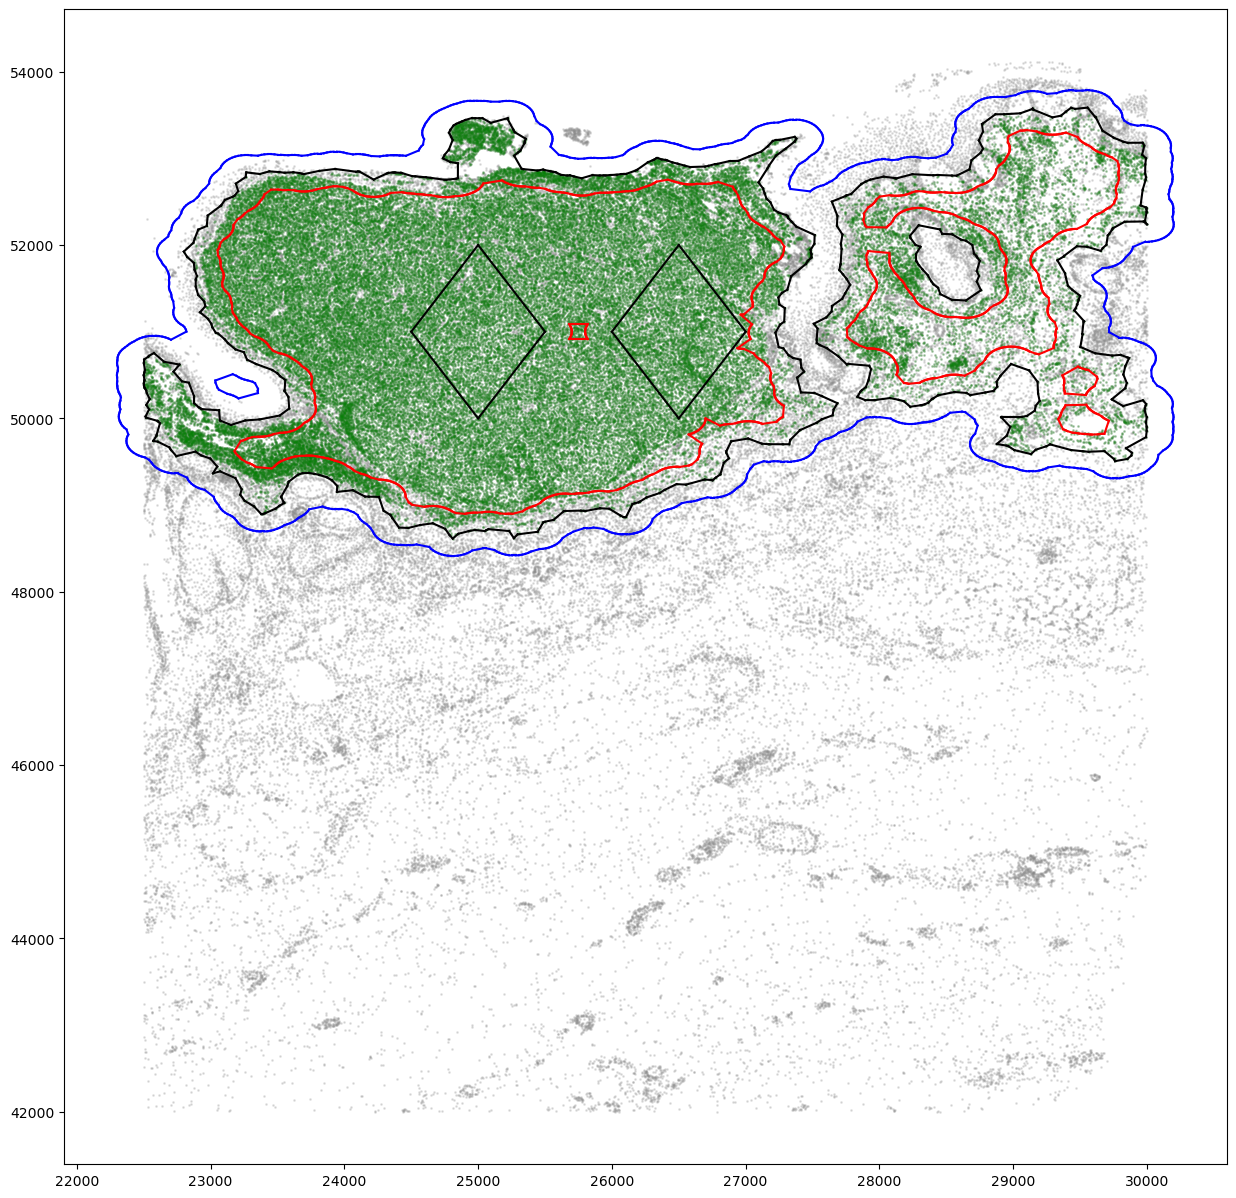

In [24]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="green", alpha=0.2)

# Bounds of points in selected commnities
for ed in boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

for ed in extended_boundary_edges_old:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

for ed in shrunken_boundary_edges_old:
    ax.plot(ed[:, 0], ed[:, 1], color="red")

plt.show()

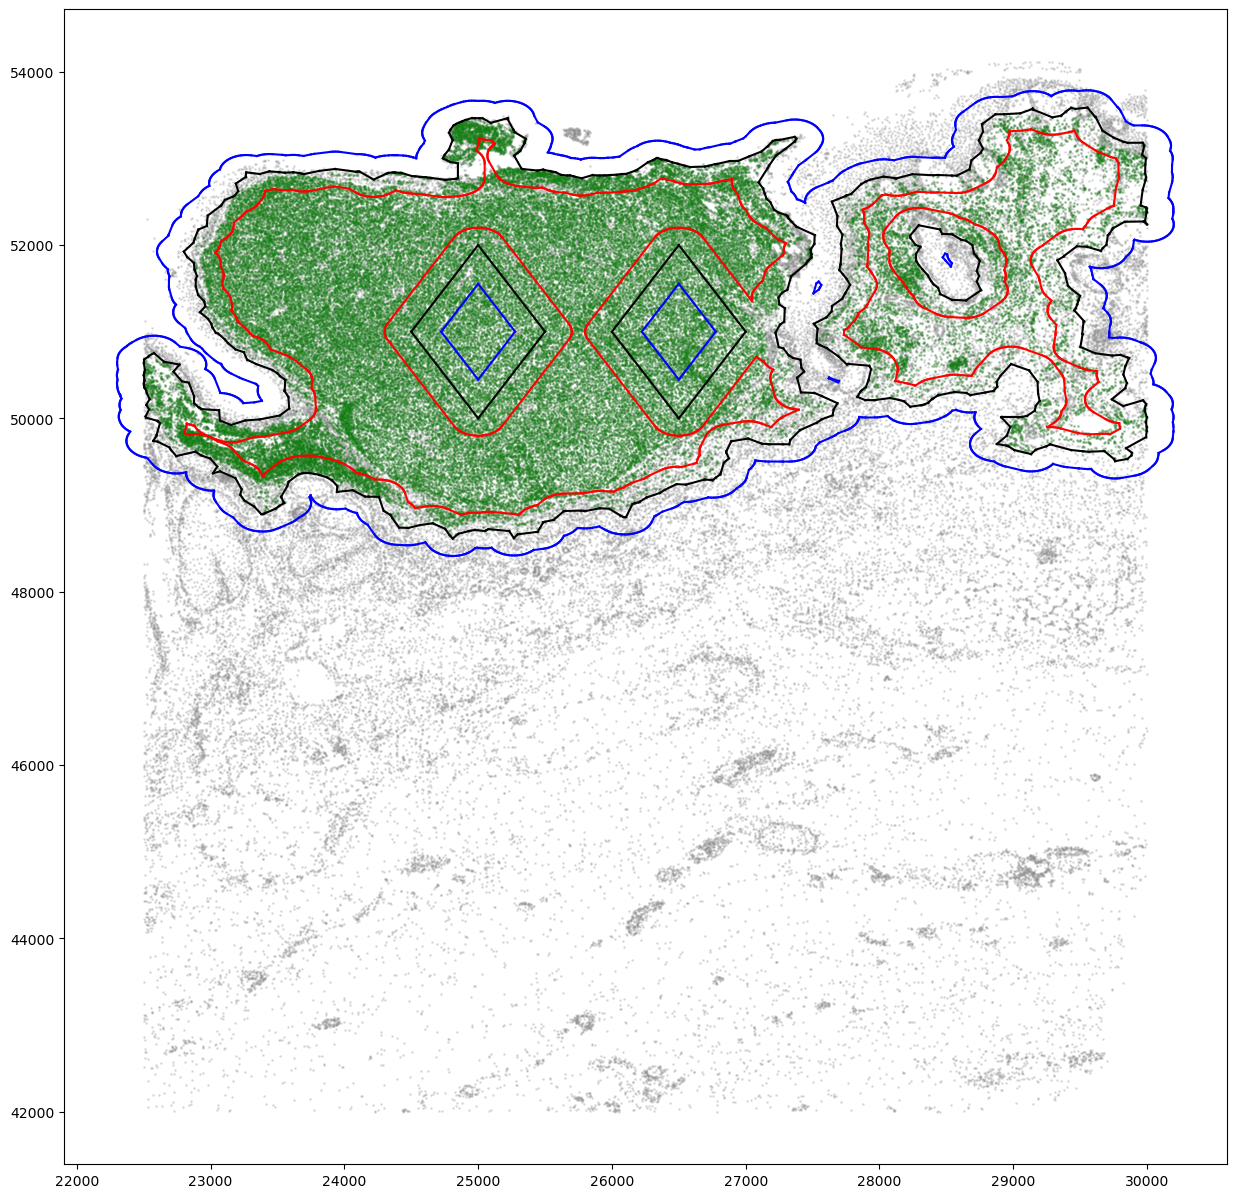

In [37]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="green", alpha=0.2)

# Bounds of points in selected commnities
for ed in boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

for ed in extended_boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

for ed in shrunken_boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="red")

plt.show()

# assignPointsToRegion

In [39]:
import _assignPointsToRegion

In [40]:
# boundaries
# shrunken_boundaries
# extended_boundaries

In [41]:
regions = ["0In", "1Bi", "2Bo", "3Out"]
adata.obs["region"] = "3Out"
adata.obs["region"] = pd.Categorical(adata.obs["region"], categories=regions, ordered=True)

In [42]:
importlib.reload(_utils)
importlib.reload(_assignPointsToRegion)

from _utils import *
from _assignPointsToRegion import assignPointsToRegion

# 0In
target = "0In"
donelist = [target]
_ = assignPointsToRegion(adata, shrunken_boundary_edges, shrunken_boundary_polygons,
                     assigncolumn = "region",
                     target=target, donelist=donelist)


Assigning a region for each cell...
Finish assigning.


In [43]:
# 1Bi
target = "1Bi"
donelist = ["0In", target]

xv, yv, grid_label = assignPointsToRegion(adata, boundary_edges, boundary_polygons,
                     assigncolumn = "region",
                     target=target, donelist=donelist)

Assigning a region for each cell...
Finish assigning.


In [44]:
# 2Bo
target = "2Bo"
donelist = ["0In", "1Bi", target]

xv, yv, grid_label = assignPointsToRegion(adata, extended_boundary_edges, extended_boundary_polygons,
                     assigncolumn = "region",
                     target=target, donelist=donelist)

Assigning a region for each cell...
Finish assigning.


In [45]:
print(set(adata.obs['region']))
print(adata.obs['region'].value_counts())

{'1Bi', '2Bo', '3Out', '0In'}
0In     49801
1Bi     36307
3Out    35452
2Bo     16256
Name: region, dtype: int64


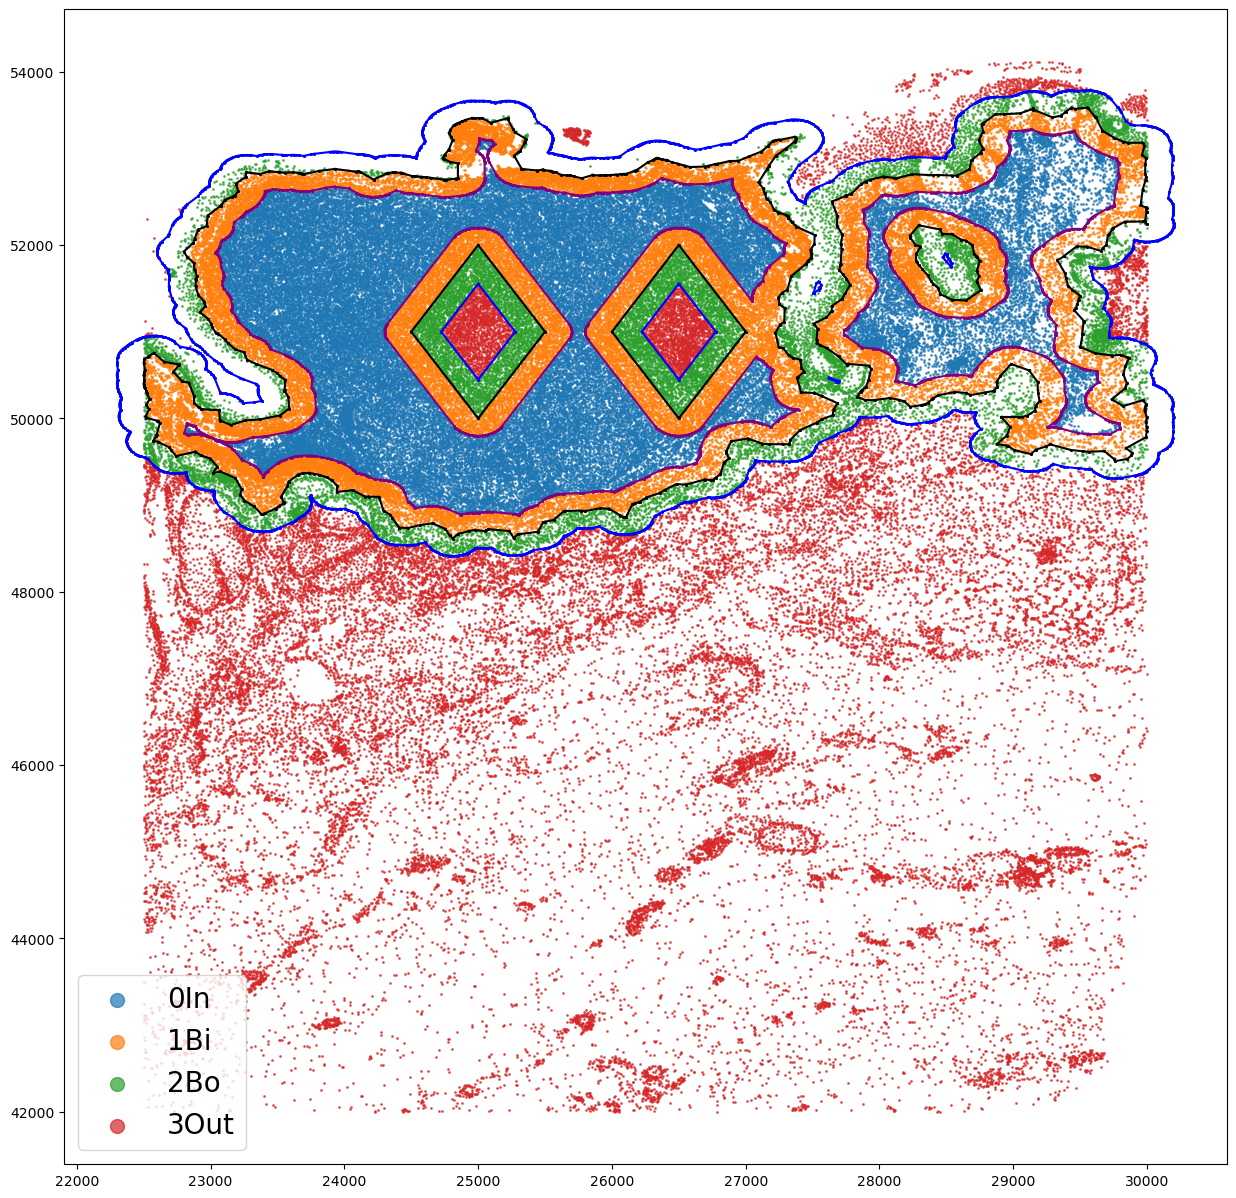

In [46]:
# import seaborn as sns

# sns.lmplot('X_centroid', 'Y_centroid', data=adata.obs, hue='region', fit_reg=False)

point_size = 1
fig, ax = plt.subplots(figsize=(15, 15))

for region in sorted(set(adata.obs['region'])):
    tmp = adata[adata.obs.region==region]
    ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.7, label = region)

for ed in boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="k", marker="o", markersize=point_size)

for ed in extended_boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="blue", marker="o", markersize=point_size)

for ed in shrunken_boundary_edges:
    ax.plot(ed[:, 0], ed[:, 1], color="purple", marker="o", markersize=point_size)
# plt.xlim(23000, 25000)
# plt.ylim(50000, 52000)

plt.legend(loc="lower left", markerscale=10, fontsize=20)
plt.show()